<a href="https://colab.research.google.com/github/luvbenz/2025-CV/blob/main/2-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Fig0943(a)(dark_blobs_on_light_background).tif to Fig0943(a)(dark_blobs_on_light_background) (46).tif


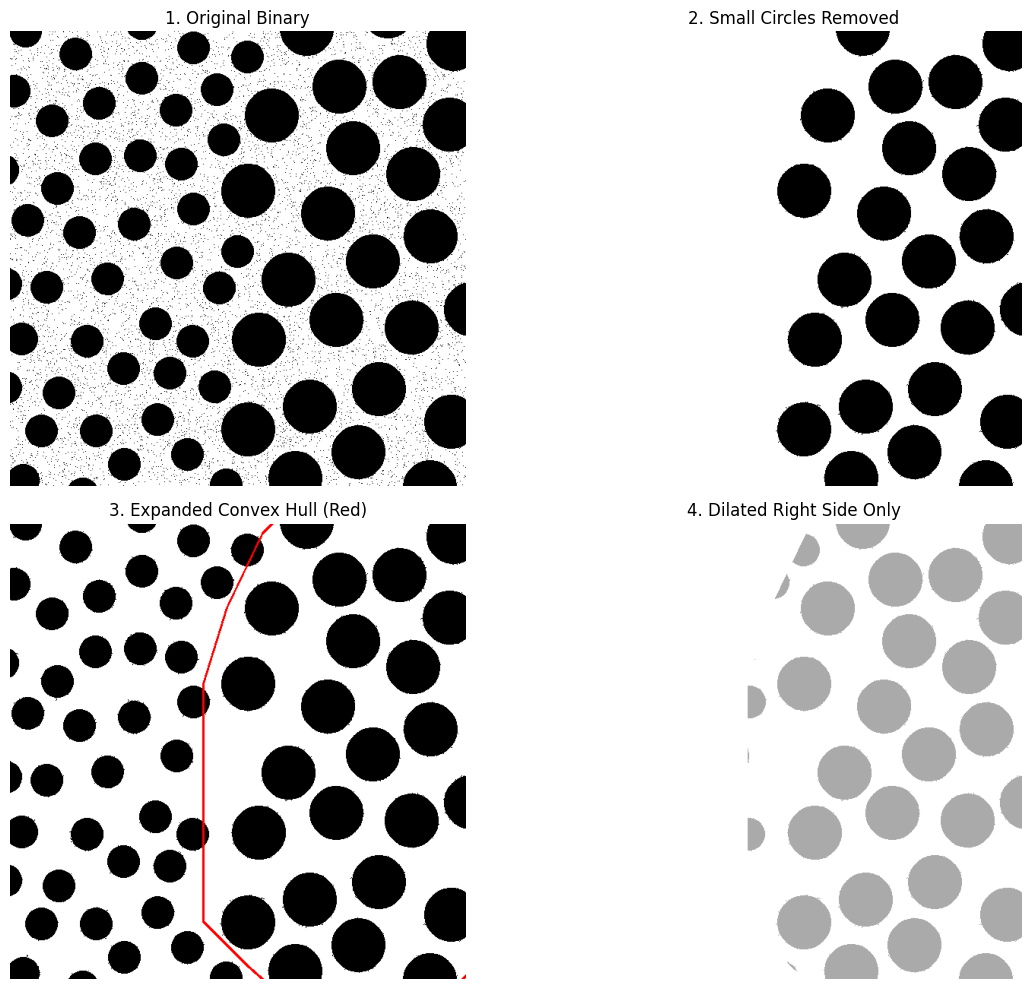

In [14]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.path import Path
from google.colab import files

# 1. 이미지 업로드
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

# 2. otsu 이진화 + 반전
_, binary = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
inv = cv.bitwise_not(binary)

# 3. connected components 분석
num_labels, labels, stats, centroids_all = cv.connectedComponentsWithStats(inv)

# 4. 큰 원 / 복원할 작은 원 분리
min_area_large = 1500
min_area_restore = 100
filtered = np.zeros_like(inv)
temp_restored = np.zeros_like(inv)
centroids = []
radii = []

for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    if area >= min_area_large:
        filtered[labels == i] = 255
        yx = np.column_stack(np.where(labels == i))
        centroid = np.mean(yx, axis=0)
        centroids.append(centroid[::-1])  # (x, y)
        radii.append(np.sqrt(area / np.pi))
    elif area >= min_area_restore:
        temp_restored[labels == i] = 255

# 5. 중심 기반 padding 적용 convexHull 점 확장
padding = int(np.mean(radii)) + 25 if radii else 30
expanded_points = []
for pt in centroids:
    x, y = pt
    expanded_points.extend([
        [x + padding, y],
        [x - padding, y],
        [x, y + padding],
        [x, y - padding],
    ])
expanded_points = np.array(expanded_points).astype(np.int32)

# 6. convex Hull 생성 및 Path 객체 변환
if len(expanded_points) >= 3:
    hull = cv.convexHull(expanded_points.reshape(-1, 1, 2)).reshape(-1, 2)
    hull_path = Path(hull)
else:
    hull = None
    hull_path = None

# 7. Hull 경계선 바깥에 있는 작은 원만 복원
restored_small = np.zeros_like(inv)
if hull_path:
    for i in range(1, num_labels):
        area = stats[i, cv.CC_STAT_AREA]
        if min_area_restore <= area < min_area_large:
            cx, cy = centroids_all[i]
            if not hull_path.contains_point((cx, cy)):
                restored_small[labels == i] = 255

# 8. 3단계 이미지: Hull + 복원된 작은 원 시각화
combined_for_hull = cv.bitwise_or(filtered, restored_small)
hull_overlay = cv.cvtColor(cv.bitwise_not(combined_for_hull), cv.COLOR_GRAY2BGR)
if hull is not None:
    cv.drawContours(hull_overlay, [hull], 0, (0, 0, 255), 2)

# 9. 4단계 이미지: convex Hull 기준 오른쪽으로 팽창
mask = np.zeros_like(inv)
if hull is not None:
    cv.drawContours(mask, [hull], 0, 255, -1)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (31, 5))  # 수평 팽창 커널
dilated_mask = cv.dilate(mask, kernel, iterations=1)

# 회색 배경 생성
dilated_gray = np.full_like(inv, 200)
hull_right_overlay = cv.cvtColor(np.full_like(inv, 255), cv.COLOR_GRAY2BGR)
hull_right_overlay[dilated_mask == 255] = (170, 170, 170)

# 기존 내용과 합성
contour_combined = cv.bitwise_or(filtered, restored_small)
contour_combined_rgb = cv.cvtColor(cv.bitwise_not(contour_combined), cv.COLOR_GRAY2BGR)
final_overlay = cv.addWeighted(contour_combined_rgb, 1, hull_right_overlay, 1, 0)

# 10. 시각화 출력
titles = [
    '1. Original Binary',
    '2. Small Circles Removed',
    '3. Expanded Convex Hull (Red)',
    '4. Dilated Right Side Only'
]
images = [
    binary,
    cv.bitwise_not(filtered),
    hull_overlay,
    final_overlay
]

plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    if images[i].ndim == 2:
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
